# Will Couples Stay Together?

Because I love asking the important questions. Also explain your predictions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from IPython.display import display, Markdown

from DataScienceUtils import GetSubsetTransform

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder


graph.style.use('fivethirtyeight')

# EDA

In [2]:
# Load data (Came from Stanford https://data.stanford.edu/hcmst)
df = pd.read_csv('data/couples.csv')

print(df.shape)
display(df.head(3))
display(df.info())

(1473, 22)


,caseid_new,marital_status,age,partner_age,education,partner_education,ethnicity,children,visits_relatives,gender,...,msa,rent,political,religion,work,lgbtq,success,age_diff_abs,gender_older,education_difference
0,22526,living with partner,52,48,bachelor's degree or higher,some college,hispanic,0.0,0,female,...,metro,rented for cash,democrat,catholic,working - as a paid employee,0,1.0,4,1,1
1,23286,living with partner,28,30,bachelor's degree or higher,bachelor's degree or higher,"white, non-hispanic",0.0,0,female,...,metro,rented for cash,democrat,jewish,working - as a paid employee,0,1.0,2,0,0
2,26315,never married,31,40,some college,high school,"white, non-hispanic",0.0,1,male,...,metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,0,0.0,9,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 22 columns):
caseid_new              1473 non-null int64
marital_status          1473 non-null object
age                     1473 non-null int64
partner_age             1473 non-null int64
education               1473 non-null object
partner_education       1473 non-null object
ethnicity               1473 non-null object
children                1473 non-null float64
visits_relatives        1473 non-null int64
gender                  1473 non-null object
house                   1473 non-null object
income                  1473 non-null object
msa                     1473 non-null object
rent                    1473 non-null object
political               1473 non-null object
religion                1473 non-null object
work                    1473 non-null object
lgbtq                   1473 non-null int64
success                 1473 non-null float64
age_diff_abs            1473 non-null int

None

## String Features

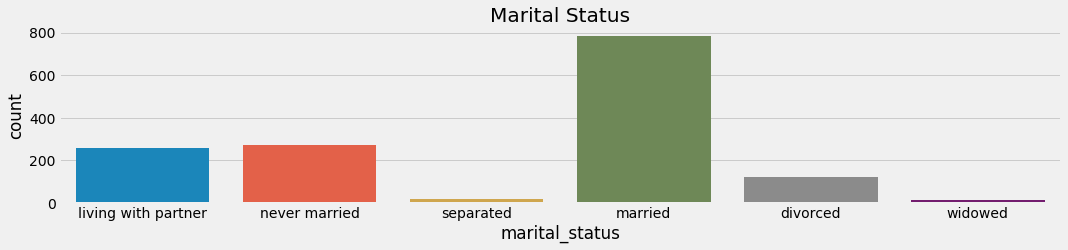

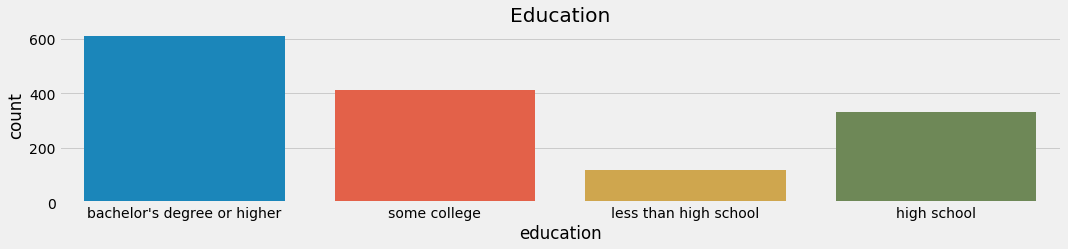

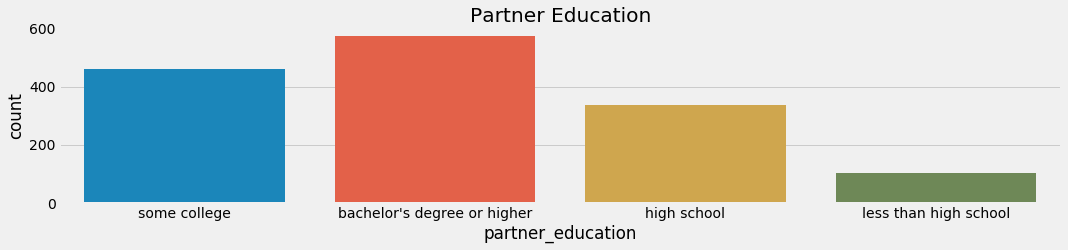

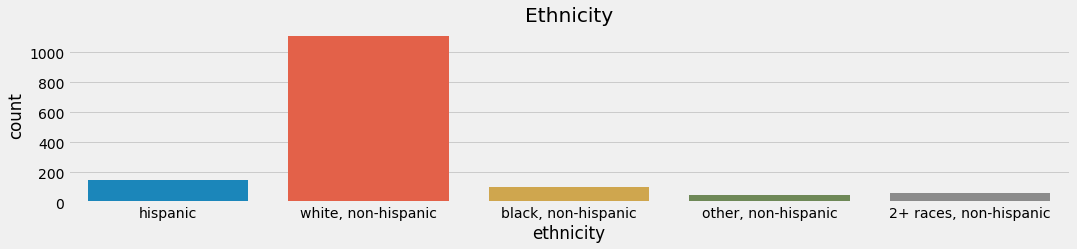

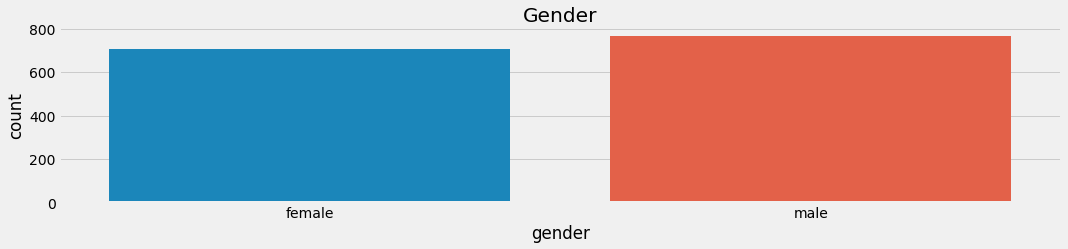

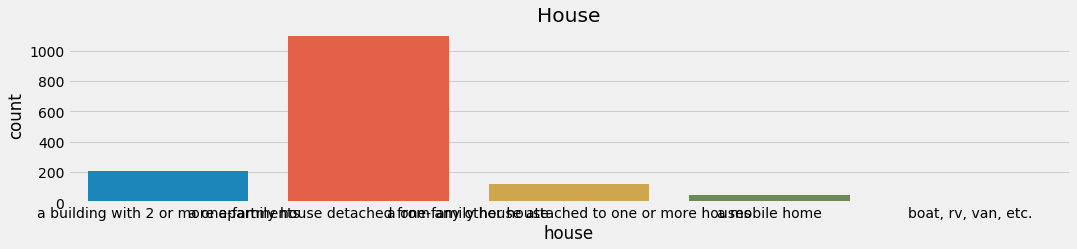

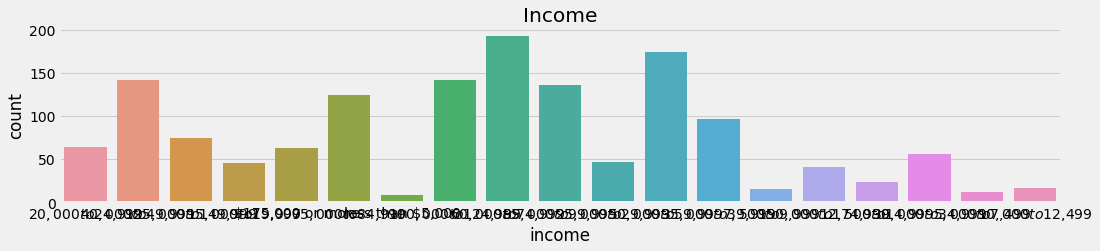

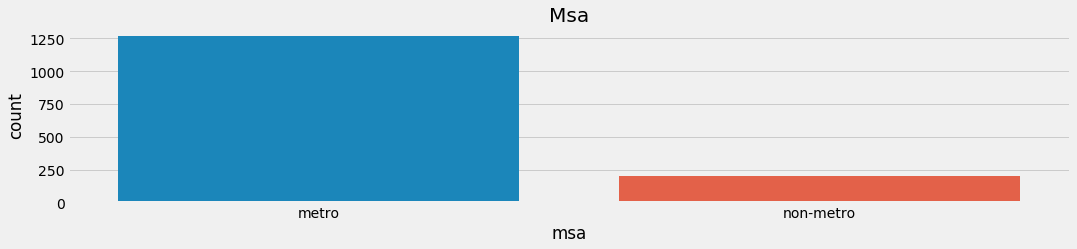

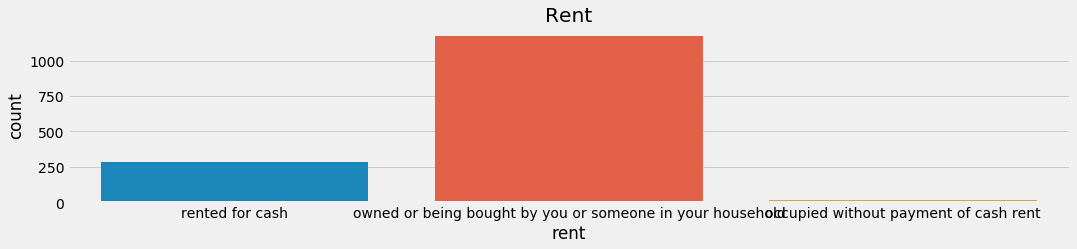

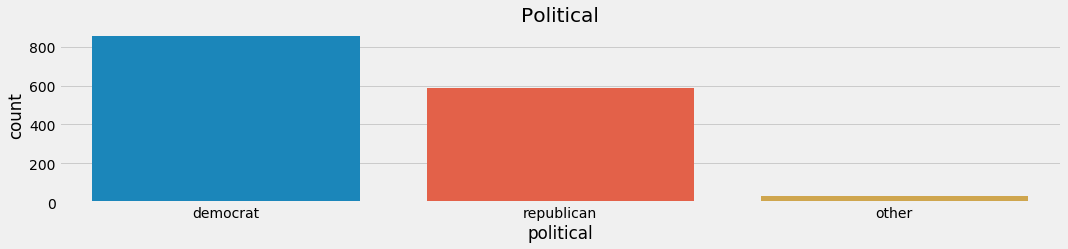

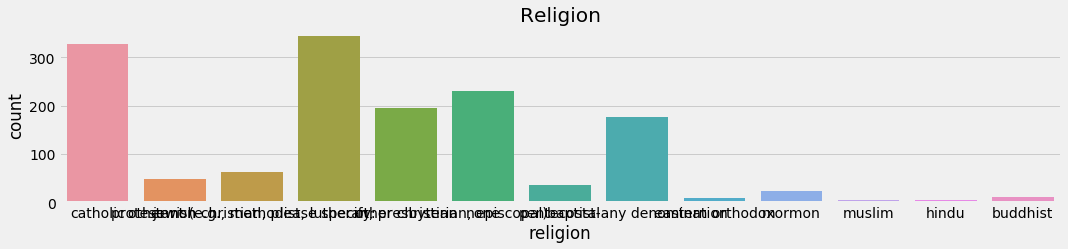

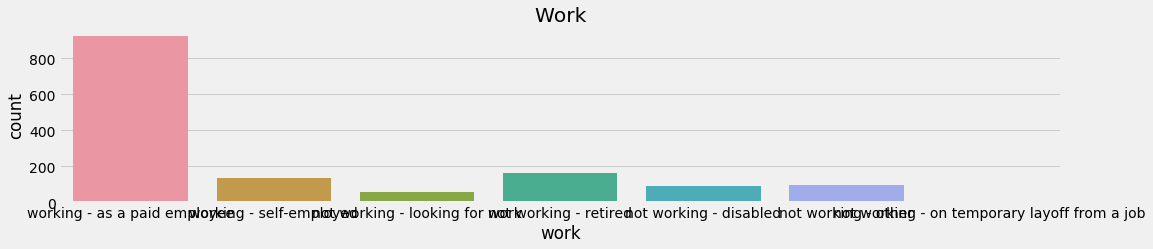

## Numeric Features

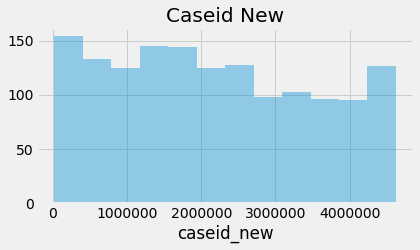

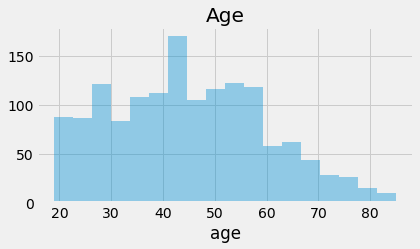

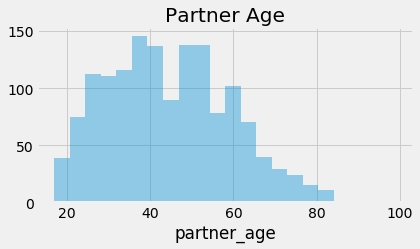

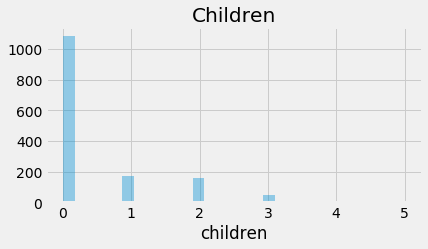

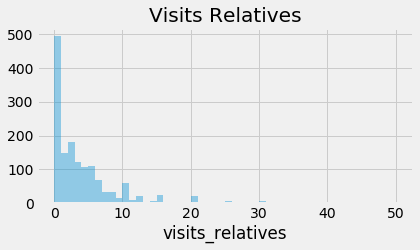

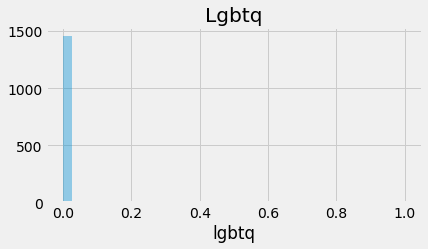

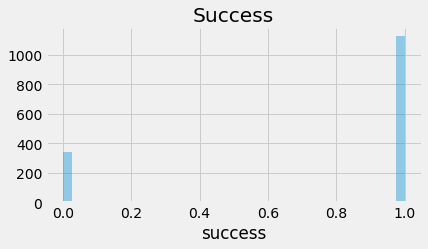

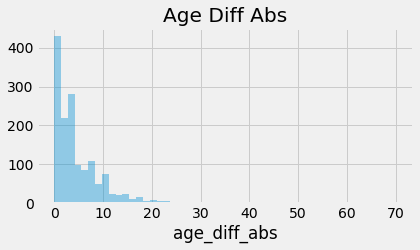

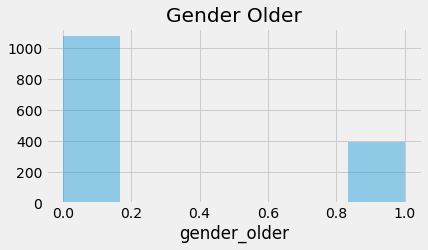

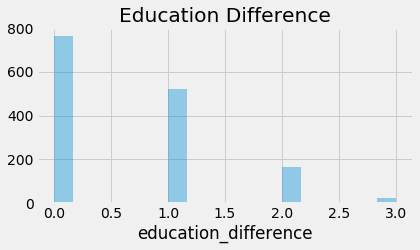

In [3]:
# Feature Exploration

display(Markdown('## String Features'))
for col in df.select_dtypes(include=['object']):
    graph.figure(figsize=(16, 3))
    graph.title(col.replace('_', ' ').title())
    sns.countplot(df[col])
    graph.show()
    
display(Markdown('## Numeric Features'))
for col in df.select_dtypes(include=['int64', 'float64']):
    graph.figure(figsize=(6, 3))
    graph.title(col.replace('_', ' ').title())
    sns.distplot(df[col], kde=False)
    graph.show()

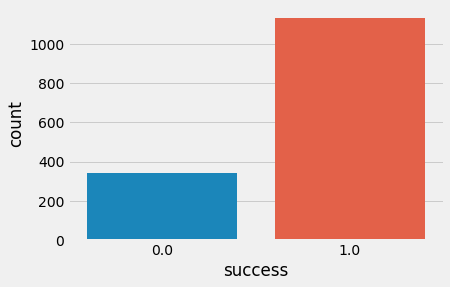

In [4]:
# Target Variable
sns.countplot(df['success'])
graph.show()

This dataset has very interesting biases. I'm going to need a score that deals with this well. Something between AUC, F1 Score, Matthews Correlation Coeffiecent.

I'm currently leaning on the Matthew and F1 score.

Also looks like Stanford did an absolutely amazing job cleaning this data! So it will be dope!

# Preping Data

In [5]:
# This feature order allows for easier slicing so don't fuck with it.
features = [
    'success',
    'age',
    'partner_age',
    'age_diff_abs',
    'children',
    'visits_relatives',
    'education',
    'marital_status',
    'partner_education',
    'gender',
    'house',
    'income',
    'msa',
    'rent',
    'political',
    'religion',
    'work',
    'gender_older',
    'education_difference'
]

df = df[features]
df = df[df['house'] != 'boat, rv, van, etc.']  # perfect information

print(df.shape)

(1472, 19)


In [6]:
# Splitting and preping data for Machine Learning
feature_names = df.columns[1:].tolist()
feature_indices = np.arange(len(feature_names))
print(feature_names, feature_indices)

def split_for(obj, continuous=True):
    return obj[:5] if continuous else obj[5:]

y, x = df['success'].values, df[df.columns[1:]].values

# Encode Labels
label_encoders = {}
for col_index, feature_name in zip(split_for(feature_indices, False), split_for(feature_names, False)):
    le = LabelEncoder()
    x[:, col_index] = le.fit_transform(x[:, col_index])
    label_encoders[feature_name] = le
    
# Unify datatypes for models like Neural Networks
x = x.astype(float)

# How does it look?
print(y.shape, x.shape)
display(x)

# Train test stratified split (This should get us pretty good resolution)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=272, stratify=y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

['age', 'partner_age', 'age_diff_abs', 'children', 'visits_relatives', 'education', 'marital_status', 'partner_education', 'gender', 'house', 'income', 'msa', 'rent', 'political', 'religion', 'work', 'gender_older', 'education_difference'] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
(1472,) (1472, 18)


array([[ 52.,  48.,   4., ...,   5.,   1.,   1.],
       [ 28.,  30.,   2., ...,   5.,   0.,   0.],
       [ 31.,  40.,   9., ...,   5.,   1.,   1.],
       ..., 
       [ 33.,  33.,   0., ...,   5.,   0.,   1.],
       [ 29.,  29.,   0., ...,   5.,   0.,   0.],
       [ 37.,  38.,   1., ...,   5.,   1.,   0.]])

(1200, 18) (272, 18) (1200,) (272,)


# Modeling

In [7]:
# Create a feature preprocessing pipeline since you cannot* standardise One Hot Features
numeric_branch = Pipeline([
    ('get-numeric', GetSubsetTransform(split_for(feature_indices, continuous=True))),
    ('standardise', StandardScaler())
])
categorical_branch = Pipeline([
    ('get-categorical', GetSubsetTransform(split_for(feature_indices, continuous=False))),
    ('one-hot', OneHotEncoder(sparse=False))
])
preprocessor = FeatureUnion(transformer_list=[
    ('numeric-branch', numeric_branch),
    ('categorical-branch', categorical_branch)
])

In [8]:
def evaluate(model, xs, ys):
    print(f'F1       = {f1_score(model.predict(xs), ys)}')
    print(f'Matthews = {matthews_corrcoef(model.predict(xs), ys)}')
    print(f'Accuracy = {accuracy_score(model.predict(xs), ys)}')

In [9]:
### Model Specification
# Random Forest
forest_grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'),
    param_grid={
        'n_estimators': [50, 100, 400],
        'max_features': ['sqrt', 'log2', None, 10, 15],
        'min_samples_split': [5, 15, 25],
        'max_depth': [15, 20, 30]
    },
    cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=3),
    n_jobs=4,
    scoring='f1'
)
forest = make_pipeline(preprocessor, forest_grid_search)

# Neural Network

In [10]:
%%time
# Train Forest
forest.fit(x_train, y_train)

print('#### Forest (Training) ####')
print(evaluate(forest, x_train, y_train))

print(forest.named_steps['gridsearchcv'].best_params_)

KeyboardInterrupt: 

In [11]:
print('#### Forest (Testing) ####')
print(evaluate(forest, x_test, y_test))
forest.named_steps['gridsearchcv'].best_params_

#### Forest (Testing) ####


NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.